In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim

from models import *
from learning import *
from utility import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
narma_df = pd.read_csv('../NARMA10.csv', header=None)
narma_df.iloc[:, :20] # visualize the first 20 columns

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.083964,0.48934,0.35635,0.25024,0.23554,0.029809,0.34099,0.021216,0.035723,0.26082,0.048365,0.40907,0.40877,0.36122,0.074933,0.32980,0.25930,0.48649,0.32450,0.40017
1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.132850,0.17536,0.37127,0.36481,0.337070,0.20447,0.33003,0.20726,0.18825,0.28343


In [3]:
x_data = torch.tensor(narma_df.iloc[0].values, dtype=torch.float32) # float 32 for better memory efficiency
y_data = torch.tensor(narma_df.iloc[1].values, dtype=torch.float32)

# 4000 tr, 1000 val, 5000 test (WARNING: load entire dataset in memory ONLY because it is small and also the NN is quite small)
retrain_x, retrain_y = x_data[:5000].to(device), y_data[:5000].to(device) # only used for retraining (train + val sets)

train_x, test_x = x_data[:5000].to(device), x_data[5000:].to(device)
train_y, test_y = y_data[:5000].to(device), y_data[5000:].to(device)

train_x, val_x = train_x[:4000].to(device), train_x[4000:].to(device)
train_y, val_y = train_y[:4000].to(device), train_y[4000:].to(device)

In [4]:
hyperparams = {
    'batch_size': [100], # full batch mode
    'lr':  [0.001, 0.003, 0.005, 0.01, 0.03, 0.05],
    'weight_decay': [0],
    'epochs': [15, 20],
    'window_size': [10, 20, 30],
    'hidden_size': [20, 30, 50],
}

grid_tdnn = GridSearch(hyperparams)

model_selection_history = grid_tdnn.tdnn_grid_search(train_x, train_y, val_x, val_y, verbose=False)
df = pd.DataFrame.from_dict(model_selection_history, orient='index')
df.to_csv('grid_tdnn_search.csv')

In [4]:
df_results = pd.read_csv('grid_tdnn_search.csv', index_col=0)
df_results.sort_values(by='val_mse', ascending=True).head(10)

,batch_size,lr,weight_decay,epochs,window_size,hidden_size,train_mse,val_mse
config_51,100,0.005,0,20,30,20,0.000132,0.000361
config_86,100,0.030,0,20,20,50,0.000121,0.000382
config_103,100,0.050,0,20,20,30,0.000227,0.000442
config_85,100,0.030,0,20,20,30,0.000185,0.000459
config_48,100,0.005,0,20,20,20,0.000271,0.000465
config_49,100,0.005,0,20,20,30,0.000185,0.000467
config_68,100,0.010,0,20,20,50,0.000046,0.000491
config_76,100,0.030,0,15,20,30,0.000198,0.000500
config_66,100,0.010,0,20,20,20,0.000245,0.000500
config_14,100,0.001,0,20,20,50,0.000183,0.000519


In [5]:
window_size = 30

tdnn = TDNN(window_size=window_size, hidden_size=20, output_size=1).to(device)
train_dataset = TDNNDataset(train_x, train_y, window_size=window_size)
val_dataset = TDNNDataset(val_x, val_y, window_size=window_size)
train_loader = data.DataLoader(train_dataset, batch_size=100, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

t_h, val_h = train_tdnn(tdnn, train_loader, val_loader, lr=0.005, weight_decay=0, epochs=20, verbose=True)

Epoch 0 - Train MSE: 0.01365102855488658 - Val MSE: 0.007145303301513195
Epoch 1 - Train MSE: 0.00508154509589076 - Val MSE: 0.0042403386905789375
Epoch 2 - Train MSE: 0.00286127989529632 - Val MSE: 0.0022872434929013252
Epoch 3 - Train MSE: 0.0014830369429546409 - Val MSE: 0.0013669150648638606
Epoch 4 - Train MSE: 0.0010986447654431687 - Val MSE: 0.0012010553618893027
Epoch 5 - Train MSE: 0.0010155521900742314 - Val MSE: 0.001128675532527268
Epoch 6 - Train MSE: 0.0009308894877904095 - Val MSE: 0.0010507748229429126
Epoch 7 - Train MSE: 0.0008670578390592709 - Val MSE: 0.0010034349979832768
Epoch 8 - Train MSE: 0.0008133251314575319 - Val MSE: 0.0009663546807132661
Epoch 9 - Train MSE: 0.0007626002690813039 - Val MSE: 0.0009289695299230516
Epoch 10 - Train MSE: 0.0007106480239599478 - Val MSE: 0.0008890466415323317
Epoch 11 - Train MSE: 0.00064999417954823 - Val MSE: 0.0008465401479043067
Epoch 12 - Train MSE: 0.0005819237274408806 - Val MSE: 0.0008096437086351216
Epoch 13 - Train MS

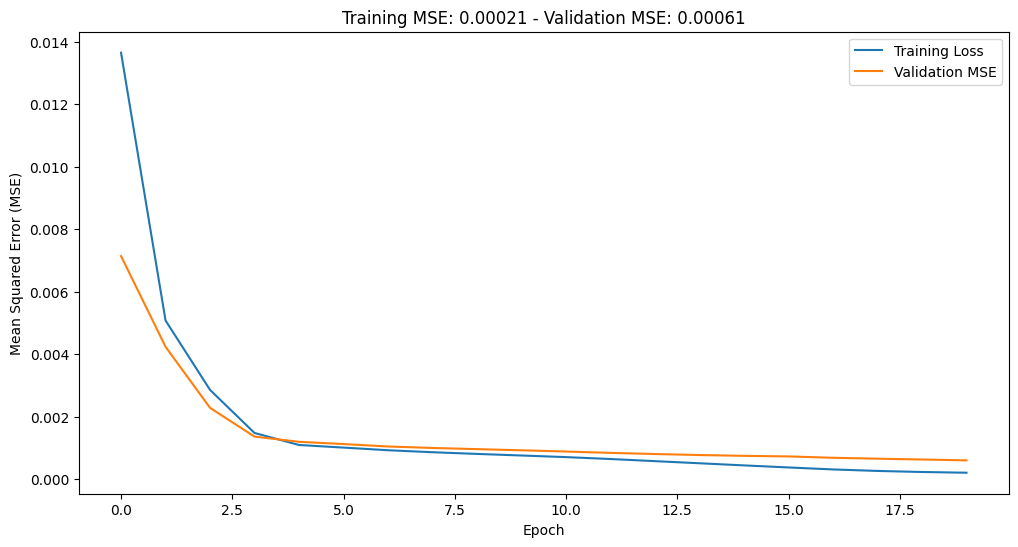

In [6]:
plot_loss(t_h, val_h)

## Retrain TDNN

In [15]:
window_size = 30
final_tdnn = TDNN(window_size=window_size, hidden_size=20, output_size=1).to(device)

retrain_dataset = TDNNDataset(retrain_x, retrain_y, window_size=window_size)
retrain_loader = data.DataLoader(retrain_dataset, batch_size=100, shuffle=False)

test_dataset = TDNNDataset(test_x, test_y, window_size=window_size)
test_loader = data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

retrain_h, test_h = train_tdnn(final_tdnn, train_loader, val_loader, lr=0.005, weight_decay=0, epochs=20, verbose=False)

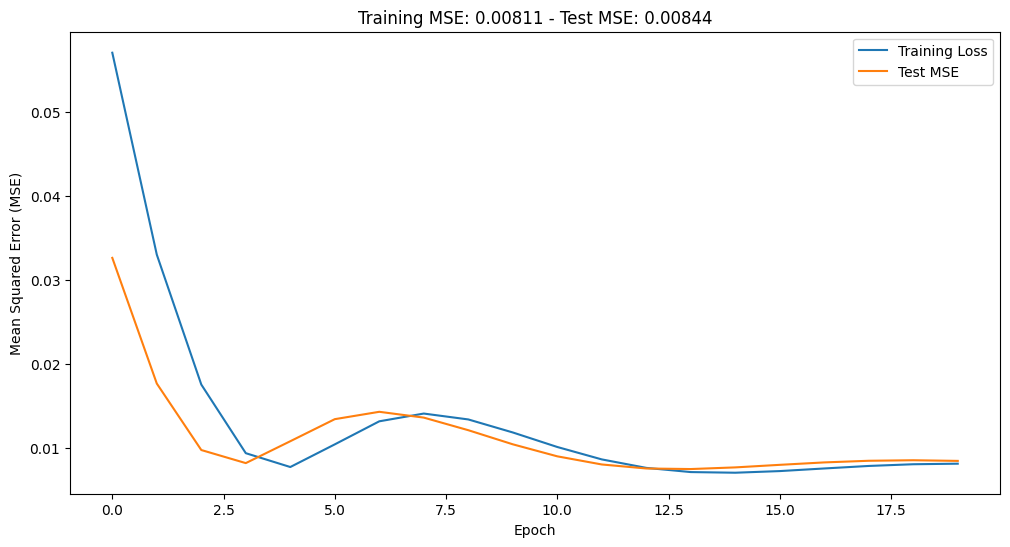

In [16]:
plot_loss(retrain_h, test_h, test=True)

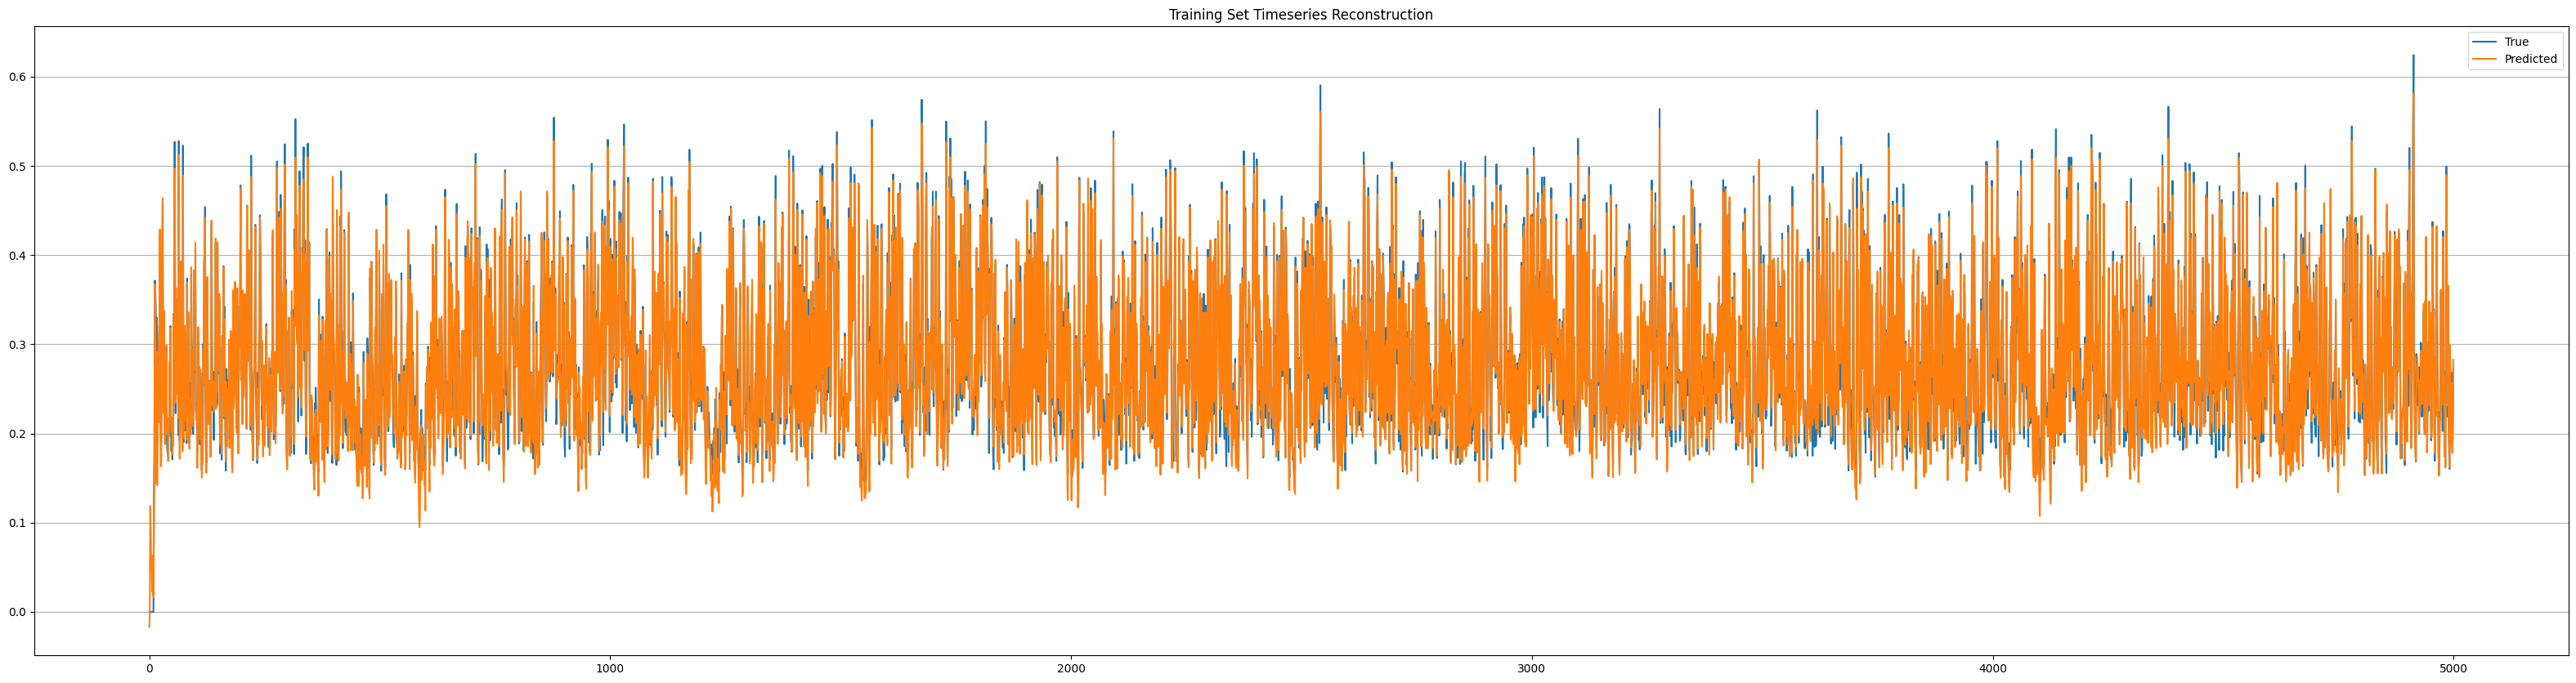

In [18]:
plt.figure(figsize=(40, 10))
plt.grid(True, axis='y')
plt.title('Training Set Timeseries Reconstruction') 

retrain_loader = data.DataLoader(retrain_dataset, batch_size=len(retrain_dataset), shuffle=False)
for x, y in retrain_loader:
    with torch.no_grad():
        out = tdnn(x)
        plt.plot(y.cpu().numpy(), label='True')
        plt.plot(out.cpu().numpy(), label='Predicted')
        plt.legend()
        plt.show()

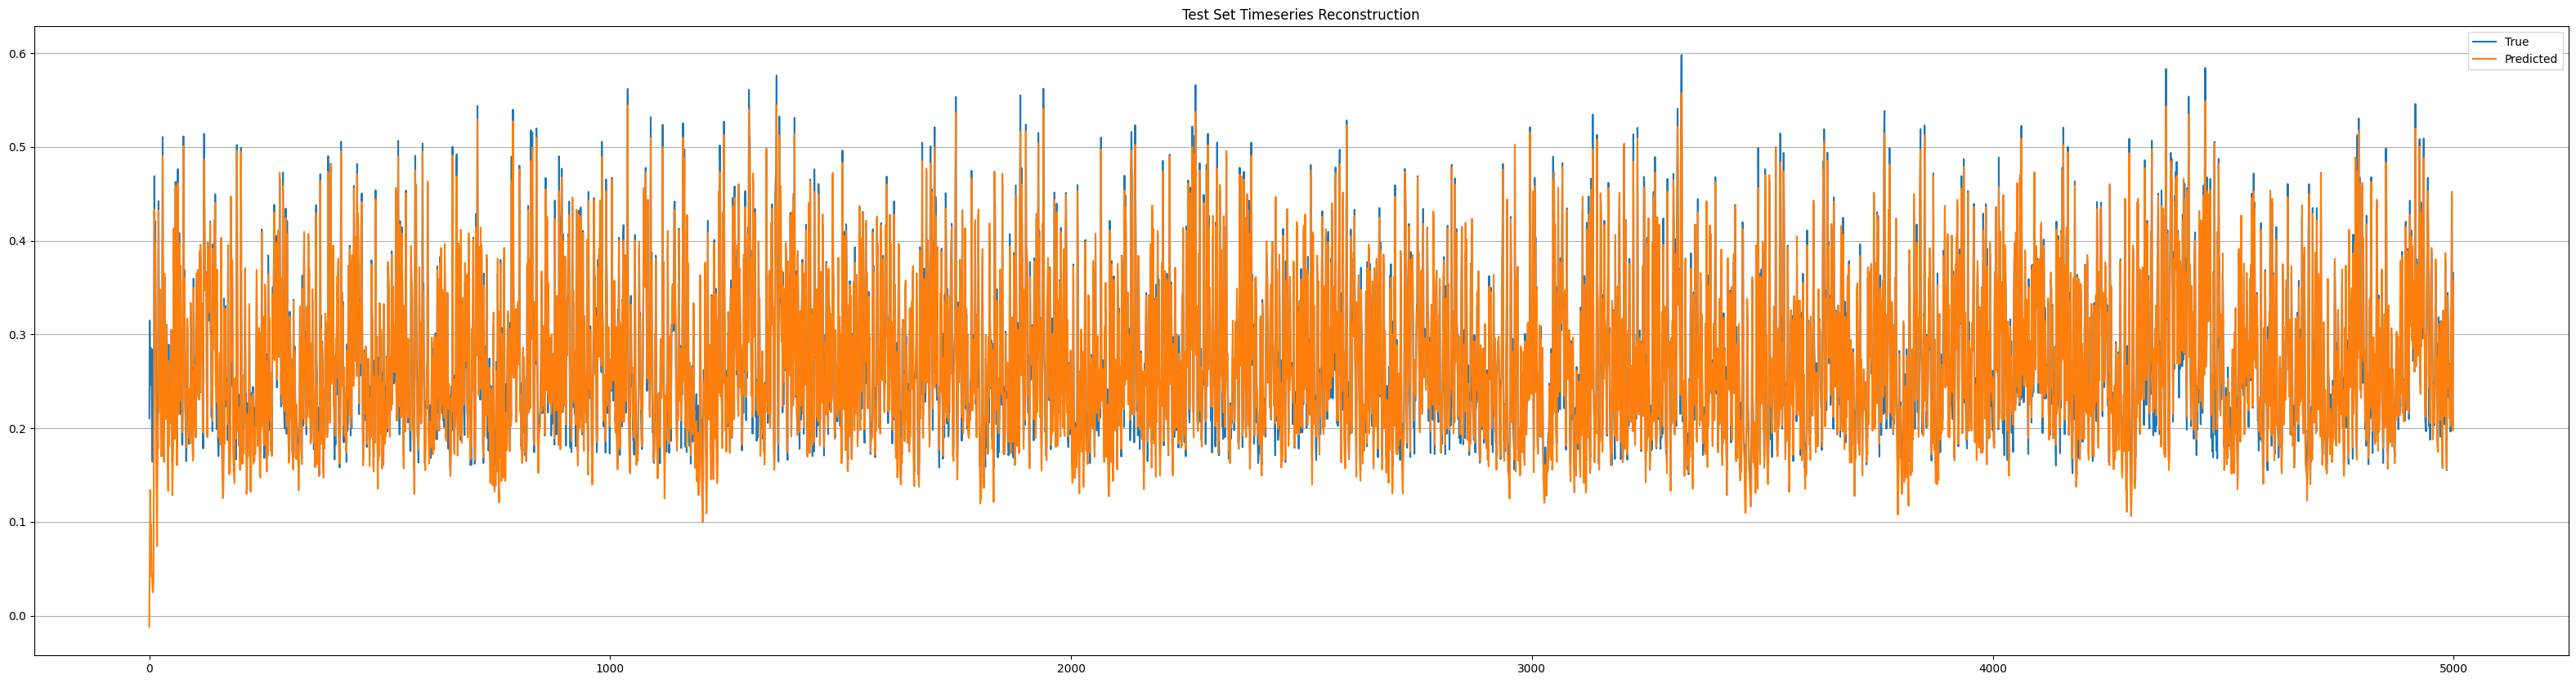

In [25]:
plt.figure(figsize=(40, 10))
plt.grid(True, axis='y')
plt.title('Test Set Timeseries Reconstruction')
for x, y in test_loader:
    with torch.no_grad():
        out = tdnn(x)
        plt.plot(y.cpu().numpy(), label='True')
        plt.plot(out.cpu().numpy(), label='Predicted')
        plt.legend()
        plt.show()